In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
import plotly.express as px


In [3]:
data = loadmat('data/ExampleDataSet_MonkeyData.mat')

# list keys 
print(data.keys())

# Check the type and shape of each key
for key in data:
    print(f"{key}: type={type(data[key])}", end='')
    if hasattr(data[key], 'shape'):
        print(f", shape={data[key].shape}")
    else:
        print()



dict_keys(['__header__', '__version__', '__globals__', 'SpikeTrains', 'sample_Hz'])
__header__: type=<class 'bytes'>
__version__: type=<class 'str'>
__globals__: type=<class 'list'>
SpikeTrains: type=<class 'numpy.ndarray'>, shape=(12, 1500, 57)
sample_Hz: type=<class 'numpy.ndarray'>, shape=(1, 1)


In [4]:
print(data['sample_Hz'])

[[1000]]


In [ ]:
spike_trains = data['SpikeTrains']

for trial_idx in range(spike_trains.shape[0]):
    df = pd.DataFrame(spike_trains[trial_idx], columns=[f'neuron{i+1}' for i in range(spike_trains.shape[2])])
    df.index.name = 'time'
    globals()[f'trial{trial_idx+1}_df'] = df


In [ ]:
# calculate the interspike interval
def calculate_interspike_intervals(spike_trains, sample_Hz):

    time_vector = np.arange(spike_trains.shape[1]+1) / sample_Hz

    interspike_intervals = []
    interspike_coefficientvariation = []

    for neuron_idx in range(spike_trains.shape[1]):
        spike_train = spike_trains[:, neuron_idx]

        isi = np.diff(np.where(spike_train == 1)[0]) / sample_Hz  
        interspike_intervals.append(isi)

        if len(isi) > 0:
            cv = np.std(isi) / np.mean(isi) if np.mean(isi) > 0 else np.nan
            interspike_coefficientvariation.append(cv)
        else:
            interspike_coefficientvariation.append(np.nan)

    return interspike_intervals, interspike_coefficientvariation, time_vector

sample_Hz = data['sample_Hz'][0][0]
for trial_idx in range(12):
    interspike_intervals, interspike_coefficientvariation, time_vector = calculate_interspike_intervals(spike_trains[trial_idx], sample_Hz)
    isi_df = pd.DataFrame(interspike_intervals).T
    isi_df.columns = [f'neuron{i+1}' for i in range(len(interspike_intervals))]
    globals()[f'isi_df_trial{trial_idx+1}'] = isi_df



In [ ]:
isi_melted_list = []
for trial_idx in range(12):
    isi_df = globals()[f'isi_df_trial{trial_idx+1}']
    melted = isi_df.melt(var_name='Neuron', value_name='Interspike Interval')
    melted['Trial'] = f'Trial {trial_idx+1}'
    isi_melted_list.append(melted)
isi_all = pd.concat(isi_melted_list, ignore_index=True)

default_trial = 'Trial 1'

fig = px.box(
    isi_all[isi_all['Trial'] == default_trial],
    x='Neuron',
    y='Interspike Interval',
    title=f'Interspike Intervals for Each Neuron ({default_trial})'
)

for trial in isi_all['Trial'].unique():
    visible = (trial == default_trial)
    trial_data = isi_all[isi_all['Trial'] == trial]
    fig.add_box(
        x=trial_data['Neuron'],
        y=trial_data['Interspike Interval'],
        name=trial,
        visible=visible
    )

fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=trial,
                    method="update",
                    args=[
                        {"visible": [
                            (t == trial) for t in isi_all['Trial'].unique()
                        ]},
                        {"title": f'Interspike Intervals for Each Neuron ({trial})'}
                    ]
                ) for trial in isi_all['Trial'].unique()
            ],
            direction="down",
            showactive=True,
            x=1.15,
            y=1.1,
            xanchor="left"
        )
    ],
    xaxis_title="Neurons",
    yaxis_title="Interspike Interval (seconds)"
)

fig.show()

In [28]:
# Prepare coefficient of variation data for all trials
cv_data = []
for trial_idx in range(12):
    _, interspike_coefficientvariation, _ = calculate_interspike_intervals(spike_trains[trial_idx], sample_Hz)
    for neuron_idx, cv in enumerate(interspike_coefficientvariation):
        cv_data.append({
            "Trial": f"Trial {trial_idx+1}",
            "Neuron": f"neuron{neuron_idx+1}",
            "CV": cv
        })
cv_df = pd.DataFrame(cv_data)

default_trial = "Trial 1"

fig = px.bar(
    cv_df[cv_df["Trial"] == default_trial],
    x="Neuron",
    y="CV",
    title=f"Coefficient of Variation of Interspike Intervals ({default_trial})"
)

# Add all traces (one per trial)
for trial in cv_df["Trial"].unique():
    visible = (trial == default_trial)
    trace_data = cv_df[cv_df["Trial"] == trial]
    fig.add_bar(
        x=trace_data["Neuron"],
        y=trace_data["CV"],
        name=trial,
        visible=visible
    )

# Dropdown menu for trial selection
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=trial,
                    method="update",
                    args=[
                        {"visible": [
                            (t == trial) for t in cv_df["Trial"].unique()
                        ]},
                        {"title": f"Coefficient of Variation of Interspike Intervals ({trial})"}
                    ]
                ) for trial in cv_df["Trial"].unique()
            ],
            direction="down",
            showactive=True,
            x=1.15,
            y=1.1,
            xanchor="left"
        )
    ],
    xaxis_title="Neurons",
    yaxis_title="Coefficient of Variation"
)

fig.show()

In [20]:
#calculate the spike rate
def calculate_spike_rate(spike_trains, sample_Hz, window_length):
    window_length_samples = int(window_length * sample_Hz)  
    max_steps = int(np.floor(spike_trains.shape[0] / window_length_samples))
    spike_rate = np.zeros((max_steps, spike_trains.shape[1]))

    for step in range(max_steps):
        start_idx = step * window_length_samples
        end_idx = start_idx + window_length_samples
        if end_idx > spike_trains.shape[0]:
            break
        spike_rate[step, :] = np.sum(spike_trains[start_idx:end_idx, :], axis=0) / window_length_samples
    
    fano_factor = np.var(spike_rate, axis=0) / np.mean(spike_rate, axis=0)
    return spike_rate, fano_factor

window_length = 0.1  
spike_rate_trials = []
fano_factor_trials = []

for i in range(12):
    spike_rate, fano_factor = calculate_spike_rate(spike_trains[i], sample_Hz, window_length)
    spike_rate_trials.append(spike_rate)
    fano_factor_trials.append(fano_factor)


In [ ]:
# Prepare spike rate arrays for all trials
spike_rate_trials_dict = {}
for i, spike_rate in enumerate(spike_rate_trials):
    df = pd.DataFrame(spike_rate, columns=[f'neuron{j+1}' for j in range(spike_rate.shape[1])])
    df['time'] = df.index
    spike_rate_trials_dict[f"Trial {i+1}"] = df

# Prepare melted 
melted_list = []
for trial_name, df in spike_rate_trials_dict.items():
    melted = df.melt(id_vars='time', var_name='Neuron', value_name='Spike Rate')
    melted['Trial'] = trial_name
    melted_list.append(melted)
all_melted = pd.concat(melted_list, ignore_index=True)

# Default 
default_trial = "Trial 1"
default_neuron = all_melted['Neuron'].unique()[0]

# Create figure with all traces (one per trial-neuron pair)
fig = px.line(
    all_melted[(all_melted['Trial'] == default_trial) & (all_melted['Neuron'] == default_neuron)],
    x='time',
    y='Spike Rate',
    color='Neuron',
    title=f"Spike Rate for {default_neuron} ({default_trial})"
)

# Add all traces 
for trial in all_melted['Trial'].unique():
    for neuron in all_melted['Neuron'].unique():
        visible = (trial == default_trial) and (neuron == default_neuron)
        trace_data = all_melted[(all_melted['Trial'] == trial) & (all_melted['Neuron'] == neuron)]
        fig.add_scatter(
            x=trace_data['time'],
            y=trace_data['Spike Rate'],
            name=f"{neuron} ({trial})",
            visible=visible
        )

# Dropdowns 
trial_options = [{'label': t, 'value': t} for t in all_melted['Trial'].unique()]
neuron_options = [{'label': n, 'value': n} for n in all_melted['Neuron'].unique()]

# visibility matrix
visibility = []
for trial in all_melted['Trial'].unique():
    for neuron in all_melted['Neuron'].unique():
        visibility.append((trial, neuron))

#  dropdown menus
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=trial,
                    method="update",
                    args=[
                        {"visible": [
                            (t == trial and n == default_neuron) for t, n in visibility
                        ]},
                        {"title": f"Spike Rate for {default_neuron} ({trial})"}
                    ]
                ) for trial in all_melted['Trial'].unique()
            ],
            direction="down",
            showactive=True,
            x=1.15,
            y=1.1,
            xanchor="left"
        ),
        dict(
            buttons=[
                dict(
                    label=neuron,
                    method="update",
                    args=[
                        {"visible": [
                            (t == default_trial and n == neuron) for t, n in visibility
                        ]},
                        {"title": f"Spike Rate for {neuron} ({default_trial})"}
                    ]
                ) for neuron in all_melted['Neuron'].unique()
            ],
            direction="down",
            showactive=True,
            x=1.15,
            y=0.9,
            xanchor="left"
        ),
    ]
)

fig.update_layout(
    xaxis_title='Time (in windows of 0.1 seconds)',
    yaxis_title='Spike Rate (Hz)',
    legend_title='Neuron'
)

fig.show()


In [ ]:
# Prepare Fano factor data for all trials
fano_factor_data = []
for i, fano_factor in enumerate(fano_factor_trials):
    for j, value in enumerate(fano_factor):
        fano_factor_data.append({
            "Trial": f"Trial {i+1}",
            "Neuron": f"neuron{j+1}",
            "Fano Factor": value
        })
fano_factor_df = pd.DataFrame(fano_factor_data)

# Default trial
default_trial = "Trial 1"

fig = px.bar(
    fano_factor_df[fano_factor_df["Trial"] == default_trial],
    x="Neuron",
    y="Fano Factor",
    title=f"Fano Factor for Each Neuron ({default_trial})"
)

# Add all traces (one per trial)
for trial in fano_factor_df["Trial"].unique():
    visible = (trial == default_trial)
    trace_data = fano_factor_df[fano_factor_df["Trial"] == trial]
    fig.add_bar(
        x=trace_data["Neuron"],
        y=trace_data["Fano Factor"],
        name=trial,
        visible=visible
    )

# Dropdown menu for trial selection
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=trial,
                    method="update",
                    args=[
                        {"visible": [
                            (t == trial) for t in fano_factor_df["Trial"].unique()
                        ]},
                        {"title": f"Fano Factor for Each Neuron ({trial})"}
                    ]
                ) for trial in fano_factor_df["Trial"].unique()
            ],
            direction="down",
            showactive=True,
            x=1.15,
            y=1.1,
            xanchor="left"
        )
    ],
    xaxis_title="Neurons",
    yaxis_title="Fano Factor"
)

fig.show()

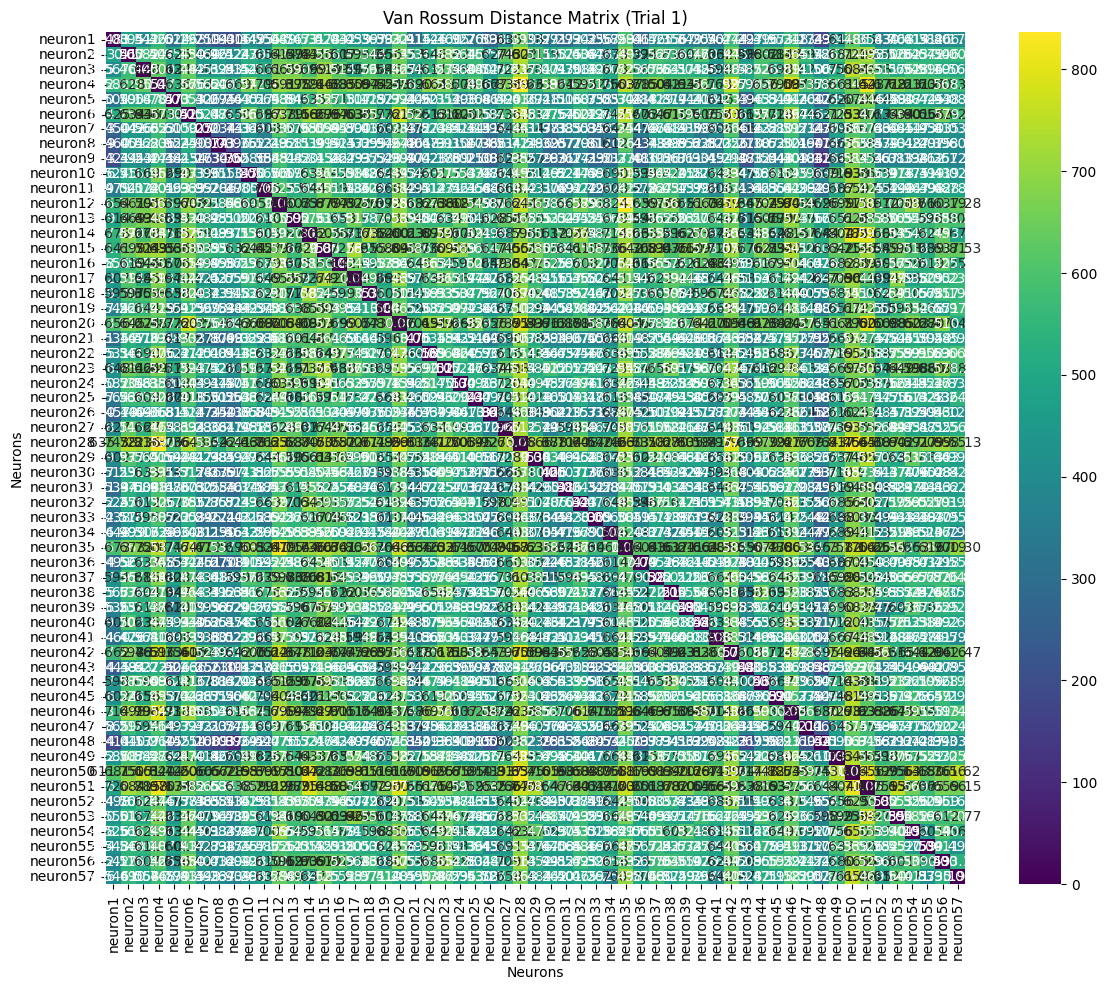

In [ ]:
# calculate the van rossum metric
def van_rossum_metric(spike_trains, sample_Hz, tau=0.005):
    time_vector = np.arange(spike_trains.shape[0]) / sample_Hz
    dt = 1 / sample_Hz
    kernel = np.exp(-np.abs(time_vector) / tau) / (tau * np.sqrt(2 * np.pi))
    
    van_rossum_distance = np.zeros((spike_trains.shape[1], spike_trains.shape[1]))
    
    for i in range(spike_trains.shape[1]):
        for j in range(i + 1, spike_trains.shape[1]):
            conv_i = np.convolve(spike_trains[:, i], kernel, mode='same')
            conv_j = np.convolve(spike_trains[:, j], kernel, mode='same')
            distance = np.sum((conv_i - conv_j) ** 2) * dt
            van_rossum_distance[i, j] = distance
            van_rossum_distance[j, i] = distance
    
    return van_rossum_distance

van_rossum_distance_trial1 = van_rossum_metric(spike_trains[0], sample_Hz)

plt.figure(figsize=(12, 10))
sns.heatmap(van_rossum_distance_trial1, annot=True, fmt=".2f", cmap='viridis', xticklabels=[f'neuron{i+1}' for i in range(van_rossum_distance_trial1.shape[0])], yticklabels=[f'neuron{i+1}' for i in range(van_rossum_distance_trial1.shape[0])])
plt.title('Van Rossum Distance Matrix (Trial 1)')
plt.xlabel('Neurons')
plt.ylabel('Neurons')
plt.tight_layout()
plt.show()  